In [3]:
import shapefile
import glob
import rasterio.mask
import rasterio.warp
import shapely.geometry
import pandas
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn import preprocessing

In [4]:
from enum import Enum

class Label(Enum):
    CACAO = 1
    COFFEE = 2
    COMPLEX_OIL = 3
    NATIVEVEGE = 4
    OIL_PALM = 5
    RUBBER = 6
    UNKNOWN = 7
    SEASONAL = 8
    URBAN = 9
    WATER = 10
    OTHER_TREE = 11
    OTHER_NO_TREE = 12
    NATIVE_NO_TREE = 13
    WATER_OTHER = 14
    PEPPER = 15
    CASSAVA = 16
    TEA = 17
    RICE = 18
    BANANA_JUNG = 19
    BABY_PALM = 20
    CUT_OFF_REGROW = 21
    NATURAL_WETLAND = 22
    INTERCROP = 23
    DECIDUOUS_FOREST = 24
    STICK_PEPPER = 25
    FLOODED_PLANTATION = 26
    PINE_TREES = 27
    COCONUT = 28
    BAMBOO = 29
    SAVANA = 30
    MANGO = 31
    OTHER_FRUIT_TREE_CROP = 32
    WATER_MINE = 33

In [5]:
def polygon_nb_px_around_coordinates(coordinate, n, dataset):
    lat = coordinate[0]
    lon = coordinate[1]

    row, col = dataset.index(lat, lon, precision=23)

    min_coord = rasterio.transform.xy(dataset.transform, row - n, col - n)
    max_coord = rasterio.transform.xy(dataset.transform, row + n, col + n)

    return shapely.geometry.box(min_coord[0], min_coord[1], max_coord[0], max_coord[1])

In [6]:
# Open shapefiles
SHAPEFILE_ROOT_PATH = "labels/"
SHAPEFILE_PATHS = glob.glob(SHAPEFILE_ROOT_PATH + "**/*.shp")

In [7]:
def labels_coordinates_from_files(paths, boundaries):
    # Create a dictionary which will contain all
    # points classified in the opened shapefiles
    # with their coordinates lat-lon
    labels_coordinates = {}

    # Initialize the dictionary
    for i in range(1, 34):
        labels_coordinates[i] = []

    # Add each points coordinate
    # in its corresponding class
    for path in paths:
        for shape_record in shapefile.Reader(path).shapeRecords():
            if shape_record.record.Class <= len(Label):
                current_list = labels_coordinates.get(shape_record.record.Class)
                
                # Add label coordinate only if this label is inside the boundaries
                if shapely.geometry.Point(shape_record.shape.points[0]).within(boundaries):
                    current_list.append(shape_record.shape.points[0])
                    labels_coordinates[shape_record.record.Class] = current_list
    
    return labels_coordinates

In [8]:
def write_raster_to_disk(raster, metadata, transform, crs, filename):
    metadata.update({
        "driver": "GTiff",
        "height": raster.shape[1],
        "width": raster.shape[2],
        "transform": transform,
        "crs": crs
    })

    # Write merged raster to disk
    with rasterio.open('./tiles/' + filename, "w", **metadata) as dest:
        dest.write(raster)

In [9]:
def raster_n_px_around_tagged_point(coordinates, nb_pixel_around, initial_raster):
    polygon = polygon_nb_px_around_coordinates(coordinates, nb_pixel_around, initial_raster)
    return rasterio.mask.mask(initial_raster, shapes=[polygon], crop=True, all_touched=True)

In [10]:
NB_PIXEL_AROUND_POINT = 4

In [11]:
def labels_points_values(label, initial_raster, labels_coordinates):
    values = []
        
    for coordinates in labels_coordinates[label]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, initial_raster)
                
        # Don't add data if all values are 'NaN'
        if not np.isnan(out_img).all():
            # Add median values of each band (excepted cirrus, tirs1, tirs2) while filtering nodata values
            values.append([np.nanmedian(out_img[i]) for i in range(0,8)])
     
    return np.array(values)

In [12]:
def write_raster_around_tagged_points(label, initial_raster, label_coordinates):    
    i = 0
    for coordinates in label_coordinates[label.value]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, initial_raster)
        
        write_raster_to_disk(
            out_img,
            initial_raster.meta.copy(),
            out_transform,
            initial_raster.crs.to_proj4(),
            filename = str(label.name) + '_' + str(i) + '.tif'
        )
        
        i += 1

In [13]:
def normalize_dataframe(dataframe, columns):
    scaler = preprocessing.MinMaxScaler() 
    scaled_values = scaler.fit_transform(dataframe[columns]) 
    dataframe[columns] = scaled_values
    return dataframe

In [14]:
def draw_bands_boxplots(df, hue, title):
    g = sns.FacetGrid(df, col="bands", col_wrap=4)
    g.fig.suptitle(title)
    g.map_dataframe(sns.boxplot, x="bands", y="value", hue=hue)
    g.add_legend()
    g.set_titles(col_template="{col_name}")
    g.set(xticklabels=[])

In [15]:
def labels_values_from_raster_files(labels, raster_paths, labels_coordinates_list):
    values = []
    
    for i, path in enumerate(raster_paths):
        with rasterio.open(path) as raster:
            for labels_coordinates in labels_coordinates_list:
                for label in labels:
                    values.append(labels_points_values(label.value, raster, labels_coordinates))
    
    return values

In [16]:
def make_dataset_from_raster_files(labels, raster_paths, labels_coordinates_list):            
    values = []
    
    for i, path in enumerate(raster_paths):
        with rasterio.open(path) as raster:
            for labels_coordinates in labels_coordinates_list:
                for label in labels:
                    for coordinates in labels_coordinates[label.value]:
                        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, raster)

                        # Don't add data if there are 'NaN' values
                        if not np.isnan(out_img).any():
                            values.append({
                                "label": label.name,
                                "out_transform": out_transform,
                                "image": out_img.tolist(),
                            })
        
    return values


In [17]:
def dataframe_from_labels_values(labels_values, columns, group_names):    
    # Create dataframes from those values
    df_list = [
        pandas.DataFrame(label_values, columns=columns).assign(group_name=group_names[i])
        for i, label_values
        in enumerate(labels_values)
    ]
    
    # Concatenate all those dataframe into one
    concat_df = pandas.concat(df_list)

    # Normalize data by columns
    return normalize_dataframe(concat_df, columns)

In [18]:
def statistics(raster_paths, labels, group_names, labels_coordinates_list, title='', describe_stats=False, asc_std_by_bands=False, draw_boxplot=True):
    # Get values for each label we are interested in
    labels_values = labels_values_from_raster_files(labels, raster_paths, labels_coordinates_list)
    
    columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic']
    df = dataframe_from_labels_values(labels_values, columns, group_names)
    
    if draw_boxplot:
        melted_df = pandas.melt(df, id_vars=['group_name'], var_name=['bands'])
        draw_bands_boxplots(melted_df, 'group_name', title)
    
    if describe_stats:
        # Print statistical data pertaining to each time period
        for group_name in group_names:
            print('\n', group_name, '\n----------------\n', df.loc[df['group_name'] == group_name].describe())
     
    # TODO: extract this code in a function
    if asc_std_by_bands:
        # For each band, list standard deviations of each time period
        bands_std = {
            band: [
                df.loc[df['group_name'] == group_name][band].std() for group_name in group_names
            ] for band in columns
        }

        # For each band list time period by ascending standard deviations
        for band in bands_std:
            std_asc = list(map(lambda arg: (group_names[arg], bands_std[band][arg]), np.argsort(np.array(bands_std[band]))))

            print('\n', band, ':\n---------------')

            for std in std_asc:
                print(std[0], ": ", std[1])

In [19]:
def shapes_from_geojson(file, names, name_column='Name', geometry_column='geometry'):
    return [shape for shape in file[file[name_column].isin(names)][geometry_column]]

In [20]:
highland_districts = [
    'Dak Nong',
    'Dak Lak',
    'Gia Lai',
    'Kon Tum'
]

southern_districts = [
    'Lam Dong',
    'Binh Phuoc',
    'Dong Nai',
    'Tay Ninh',
    'Binh Duong',
    'TP. Ho Chi Minh',
    'Ba Ria - Vung Tau',
    'Long An',
    'Tien Giang',
    'Ben Tre',
    'Dong Thap',
    'Vinh Long',
    'Tra Vinh',
    'An Giang',
    'Can Tho',
    'Hau Giang',
    'Soc Trang',
    'Kien Giang',
    'Bac Lieu',
    'Ca Mau'
]

district_file = gpd.read_file("./districts/diaphantinh.geojson")
soil_file = gpd.read_file("./soilmap/soilmap.geojson")

vietnam_shape = shapely.ops.unary_union([shape for shape in district_file['geometry']])
selected_region = shapely.geometry.box(106.9998606274592134, 10.9999604855719539, 109.0000494390797456, 15.5002505644255208)
boundaries_shape = vietnam_shape & selected_region

# NOTE: only regions, districts and soils where there's coffe are listed

# Regions
southern_districts_shape = shapely.ops.unary_union(shapes_from_geojson(district_file, southern_districts))
highland_districts_shape = shapely.ops.unary_union(shapes_from_geojson(district_file, highland_districts))

# Districts
districts = [
    shapely.ops.unary_union(shapes_from_geojson(district_file, [district]))
    for district
    in ['Gia Lai', 'Dak Lak', 'Dak Nong', 'Lam Dong']
]

# Soils
soils = [
    shapely.ops.unary_union(shapes_from_geojson(soil_file, [soil], 'domsoil'))
    for soil
    in ['Fa', 'Af', 'Ao', 'Fr', 'Fo']
]

In [21]:
# Get labels coordinates of the region of interest
LABELS_COORDINATES = labels_coordinates_from_files(SHAPEFILE_PATHS, boundaries_shape)
SOUTHERN_LABELS_COORDINATES = labels_coordinates_from_files(SHAPEFILE_PATHS, southern_districts_shape)
HIGHLAND_LABELS_COORDINATES = labels_coordinates_from_files(SHAPEFILE_PATHS, highland_districts_shape)

DISTRICTS_COORDINATES = [
    labels_coordinates_from_files(SHAPEFILE_PATHS, district)
    for district
    in districts
]

SOILS_COORDINATES = [
    labels_coordinates_from_files(SHAPEFILE_PATHS, soil)
    for soil
    in soils
]

In [27]:
labels = [Label.COFFEE, Label.PEPPER, Label.NATIVEVEGE, Label.TEA, Label.URBAN, Label.WATER]
dataset = make_dataset_from_raster_files(labels, ['./Vietnam_2017_january_march/merged.tif'], [LABELS_COORDINATES])

with open('dataset.json', 'w') as f:
    json.dump(dataset, f)

#  Coffee comparison to other entities

Il semble plus facile de distinguer le café des autres labels pendant la saison sèche. En effet, en regardant les différentes boîtes à moustache, on remarque qu'il est plus facile de différencer les labels avec les canaux _coastal aerosol_, _blue_, _green_, _red_ et _nir_ en saison sèche qu'en saison humide.

On remarque aussi que le café prend des valeurs proches du poivre, du thé et de l'eau. Toutefois, le café s'écarte un peu de poivre avec le canal _red_ et du thé et de l'eau avec le canal _nir_ même s'il reste encore un assez grand chevauchement entre leurs données.  

In [22]:
labels = [Label.COFFEE, Label.PEPPER, Label.NATIVEVEGE, Label.TEA, Label.URBAN, Label.WATER]
group_names = [label.name for label in labels]

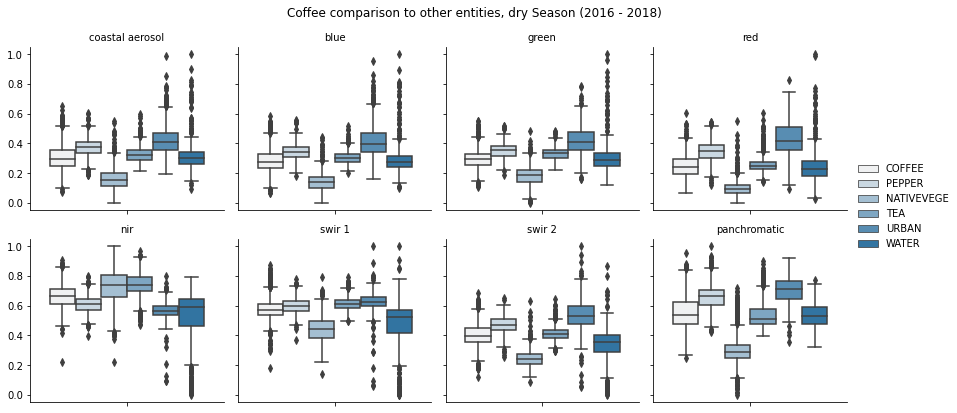

In [48]:
statistics(['./Vietnam_2016-2018_dry_season/merged.tif'], labels, group_names, [LABELS_COORDINATES], 'Coffee comparison to other entities, dry Season (2016 - 2018)')

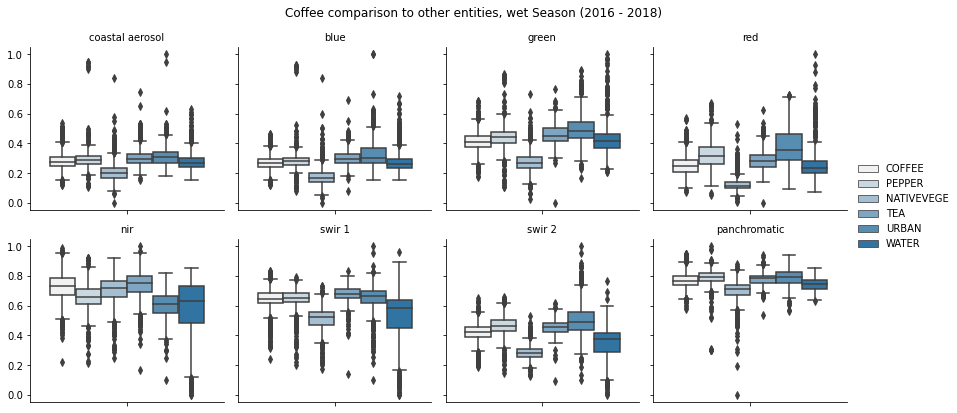

In [49]:
statistics(['./Vietnam_2016-2018_wet_season/merged.tif'], labels, group_names, [LABELS_COORDINATES], 'Coffee comparison to other entities, wet Season (2016 - 2018)')

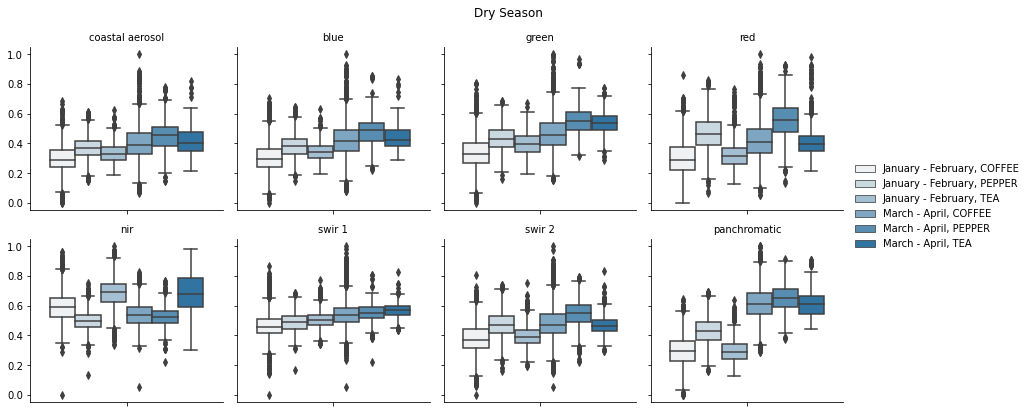

In [25]:
raster_paths = [
    './Vietnam_01_02/merged.tif',
    './Vietnam_03_04/merged.tif',
]

labels = [Label.COFFEE, Label.PEPPER, Label.TEA]

group_names = [
    'January - February, COFFEE',
    'January - February, PEPPER',
    'January - February, TEA',
    'March - April, COFFEE',
    'March - April, PEPPER',
    'March - April, TEA',
]

statistics(raster_paths, labels, group_names, [LABELS_COORDINATES], 'Dry Season')

In [ ]:
statistics(['./Vietnam_2014_2020/merged.tif'], labels, group_names, [LABELS_COORDINATES], 'Coffee comparison to other entities (2014 - 2020)')

# Coffee comparison by season
Au Vietnam, il y a deux saisons : la saison sèche et la saison humide. La saison sèche commence en novembre et fini en avril. La saison humide, quant à elle, commence mai et fini en octobre [1].

Si l'on étudie la variabilité des données du café à travers ces deux saisons, on observe que la variabilité est tantôt meilleur en saison sèche et tantôt meilleure en saison humide.

Sur les années 2014 à 2016, la saison humide à moins de variabilité à part pour le canal _nir_ alors que pendant les années 2016 à 2018, la variabilité est plus faible en saison sèche pour tous les canaux sauf _red_, _swir1_, _swir2_, et _panchromatic_.

Pour ce qui est des valeurs médianes, on remarque une net augmentation du canal _nir_, de ~0.43 à ~0.65, en saison humide. Le canal _green_ augmente lui aussi, mais en 2016-2018 plus fortement, passant de ~0.35 à ~0.45 pour les années 2014 à 2016 et ~0.51 en 2016 à 2018.

Tous les canaux ont tendances à légèrement augmenter à part _red_, _panchromatic_ et _swir2_ qui baissent légèrement en saison humide.

[1] https://www.britannica.com/place/Vietnam/Climate, Climate of Vietnam, Britannica

In [23]:
raster_paths = [
    './Vietnam_2014-2016_dry_season/merged.tif',
    './Vietnam_2016-2018_dry_season/merged.tif',
    './Vietnam_2014-2016_wet_season/merged.tif',
    './Vietnam_2016-2018_wet_season/merged.tif'
]

group_names = [
    'Dry Season (2014 - 2016)',
    'Dry Season (2016 - 2018)',
    'Wet Season (2014 - 2016)',
    'Wet Season (2016 - 2018)'
]


 Dry Season (2014 - 2016) 
----------------
        coastal aerosol         blue        green          red          nir  \
count      4114.000000  4114.000000  4114.000000  4114.000000  4114.000000   
mean          0.398606     0.417663     0.365532     0.422664     0.418018   
std           0.104189     0.117785     0.116728     0.138610     0.070874   
min           0.000000     0.000000     0.010860     0.000000     0.002693   
25%           0.333333     0.344743     0.285068     0.329087     0.371553   
50%           0.387387     0.403423     0.352941     0.402383     0.417981   
75%           0.458333     0.488998     0.437104     0.504964     0.463832   
max           0.954955     1.000000     0.876018     1.000000     0.659869   

            swir 1       swir 2  panchromatic  
count  4114.000000  4114.000000   4114.000000  
mean      0.519723     0.441576      0.632618  
std       0.090688     0.106360      0.083230  
min       0.011706     0.031847      0.353535  
25%       0

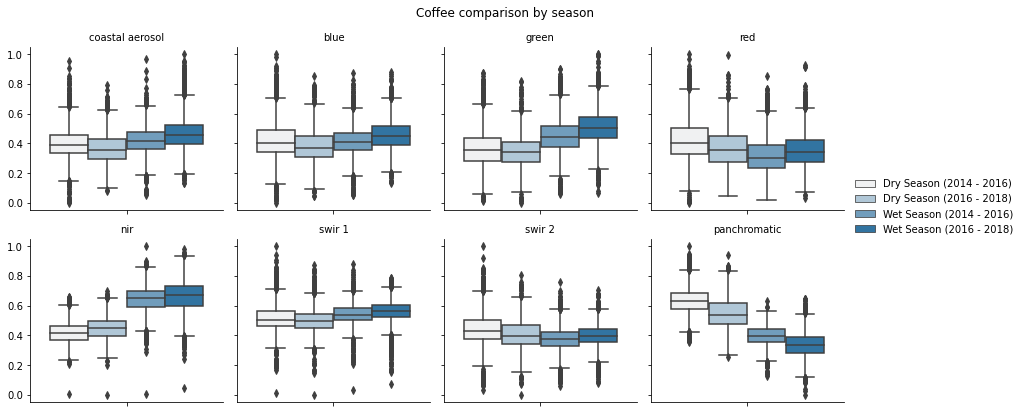

In [24]:
statistics(raster_paths, [Label.COFFEE], group_names, [LABELS_COORDINATES], 'Coffee comparison by season', True)

## Coffee comparison each two months (2014-2020)
Ici, on compare les valeurs des canaux du café deux mois par deux mois en prenant une médiane de toutes les données récoltées entre 2014 à 2020.

On remarque alors quelles sont les périodes qui ont le moins de variabilité et l'évolution des canaux à travers les mois.

### Contexte
Au Vietnam, la récolte du café commence en octobre [1] et prend fin de décembre à janvier [2], [3].

Après la récolte, les arbres à café sont taillés pour laisser plus lumière passer et c'est de janvier à avril où le caféier est fortement arrosé [2].

En février se déroule le Têt, la fête du nouvel an lunaire, et il est possible que la café soit volontairement abondamment arosé pour fleurir pendant Têt. 

[1] http://www.fao.org/3/ap301e/ap301e.pdf, "Diversification by smallholder farmers: Vietnam Robusta Coffee", AGSF, p.9

[2] ibid., p.19

[3] http://amarin.com.vn/coffee-harvest-season, "Harvest Season", AmaRin

### Évolution
C'est à partir de mai que le canal _nir_ augmente significativement, la médiane augmentant de 0.417 à 0.653.

En mars à avril, le canal rouge est au plus haut. En effet la médiane passe à 0.404 alors qu'elle était à 0.324 et qu'elle retombe ensuite à 0.333.

On observe aussi que _panchromatic_ augmente en mars à avril.

Le canal _green_, quant à lui, est à son plus haut en mai à juin et juillet à août.

### Variabilité
Voici les mois qui ont le moins de variabilité pour certains canaux :
- Septembre à octobre : coastal aerosol, blue, green, swir1, swir2, panchromatic
- Novembre à décembre : red 
- Mars à avril : _nir_

Septembre à octobre est la période avec la plus petite variabilité pour toutes les bandes de fréquences sauf _red_ et _nir_.

### Proportion de nuage moyenne
Cette proportion a été calculée à partir du script de téléchargement avec : 

```
merged_image_collections.aggregate_stats('CLOUD_COVER').getInfo()
```

- Janvier à février : 28.71%
- Mars à avril : 23.30%
- Mai à juin : 37.40%
- Juillet à août : 45.11%
- Septembre à octobre : 39.66%
- Novembre à décembre : 38.90%

In [25]:
raster_paths = [
    './Vietnam_01_02/merged.tif',
    './Vietnam_03_04/merged.tif',
    './Vietnam_05_06/merged.tif',
    './Vietnam_07_08/merged.tif',
    './Vietnam_09_10/merged.tif',
    './Vietnam_11_12/merged.tif'
]

group_names = [
    'January - February',
    'March - April',
    'May - June', 
    'July - August',
    'September - October',
    'November - December'
]


 January - February 
----------------
        coastal aerosol         blue        green          red          nir  \
count      4114.000000  4114.000000  4114.000000  4114.000000  4114.000000   
mean          0.263595     0.325870     0.406636     0.331721     0.458164   
std           0.072295     0.082910     0.067680     0.080666     0.074463   
min           0.014401     0.050633     0.187394     0.122526     0.018229   
25%           0.216022     0.269961     0.360158     0.273684     0.409470   
50%           0.259226     0.318403     0.402082     0.324211     0.456690   
75%           0.311431     0.379747     0.447383     0.383895     0.503491   
max           0.590459     0.688413     0.709060     0.718737     0.733678   

            swir 1       swir 2  panchromatic  
count  4114.000000  4114.000000   4114.000000  
mean      0.516560     0.431599      0.498858  
std       0.077021     0.085757      0.071190  
min       0.090942     0.086197      0.287206  
25%       0.46927

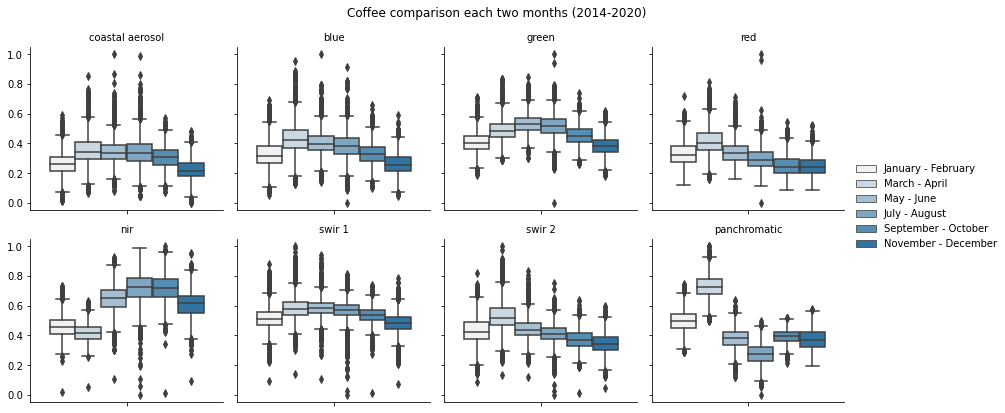

In [26]:
statistics(raster_paths, [Label.COFFEE], group_names, [LABELS_COORDINATES], 'Coffee comparison each two months (2014-2020)', True, True)

In [27]:
labels = [Label.COFFEE, Label.PEPPER, Label.NATIVEVEGE, Label.TEA, Label.URBAN, Label.WATER]

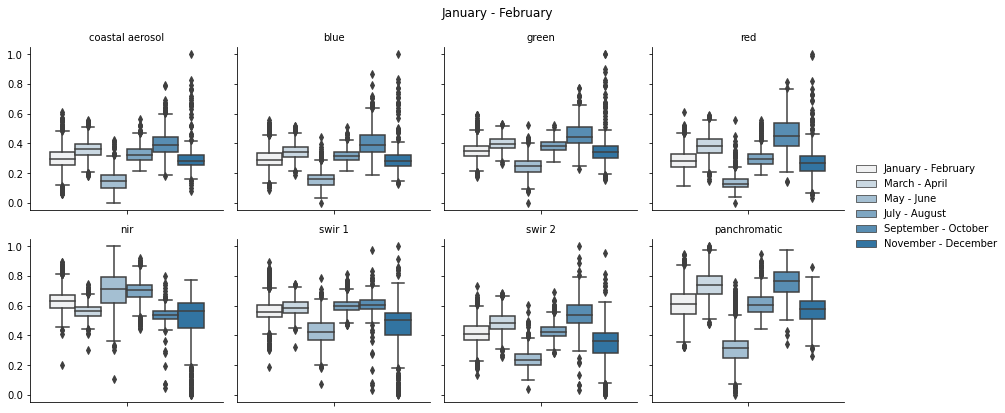

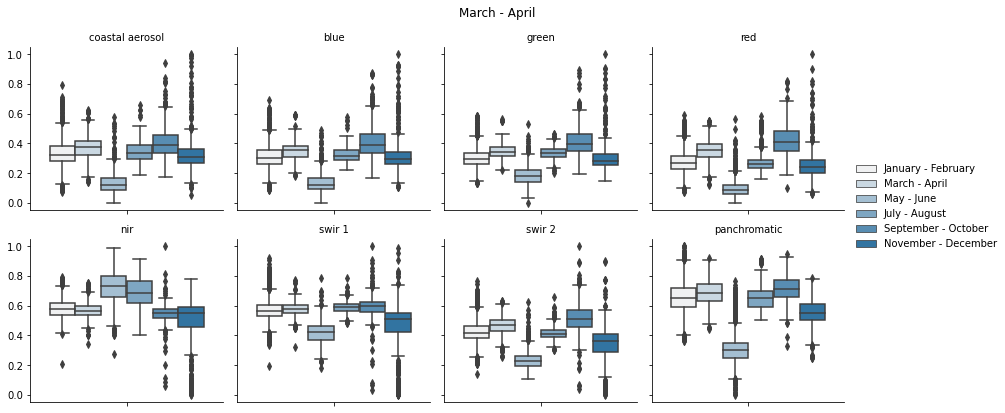

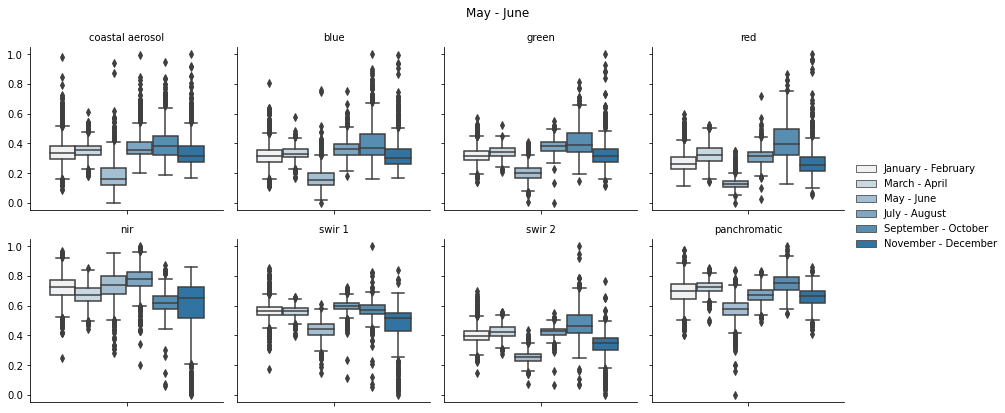

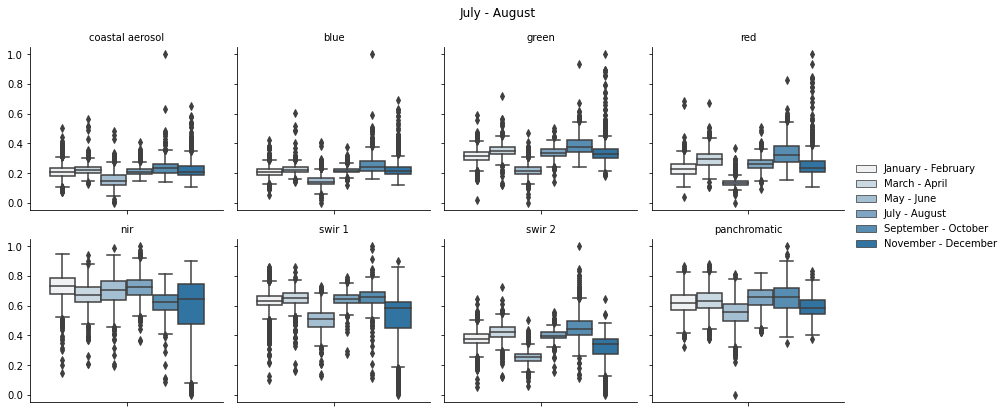

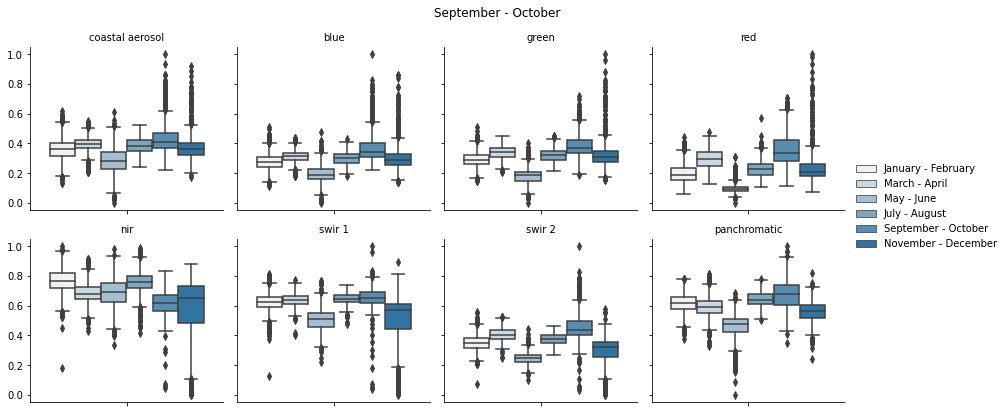

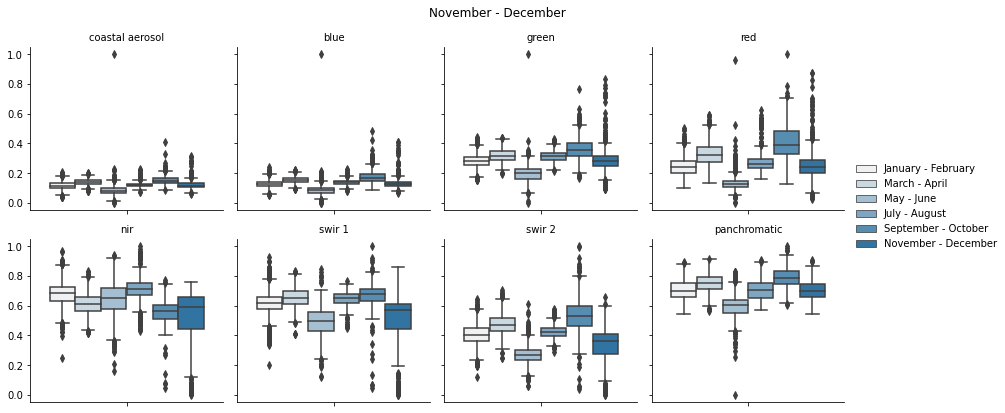

In [28]:
for i, raster_path in enumerate(raster_paths):
    statistics([raster_path], labels, group_names, [LABELS_COORDINATES], group_names[i])

# Coffee comparison by regions (2014-2020)

Il y a moins de variabilité dans la région _Highland_, même si la région _Southern_ à une plus petite variabilité pour les bandes de fréquences _coastal aerosol_ et _panchromatic_.

Dans ces deux régions, le café se dinstingue principalement par les canaux _panchromatic_, _red_, _coastal aeorosol_ et _blue_. Les différences de médianes étant de 0.092 pour _panchromatic_, 0.086 pour _red_, 0.081 pour _coastal aerosol_ et 0.07 pour _blue_.

In [29]:
labels_coordinates_list = [
    SOUTHERN_LABELS_COORDINATES,
    HIGHLAND_LABELS_COORDINATES
]

group_names = [
    'Southern Vietnam',
    'Highland Vietnam'
]


 Southern Vietnam 
----------------
        coastal aerosol         blue        green          red          nir  \
count      2709.000000  2709.000000  2709.000000  2709.000000  2709.000000   
mean          0.409350     0.412601     0.418830     0.372083     0.680212   
std           0.111188     0.127655     0.140800     0.147095     0.100812   
min           0.000000     0.000000     0.000000     0.000000     0.000000   
25%           0.341478     0.330179     0.320186     0.268065     0.610904   
50%           0.405213     0.401788     0.411446     0.355455     0.686955   
75%           0.475463     0.489485     0.502320     0.455086     0.752631   
max           0.849551     0.925868     1.000000     0.927742     1.000000   

            swir 1       swir 2  panchromatic  
count  2709.000000  2709.000000   2709.000000  
mean      0.593496     0.486007      0.358745  
std       0.096915     0.112736      0.111683  
min       0.000000     0.000000      0.000000  
25%       0.531198 

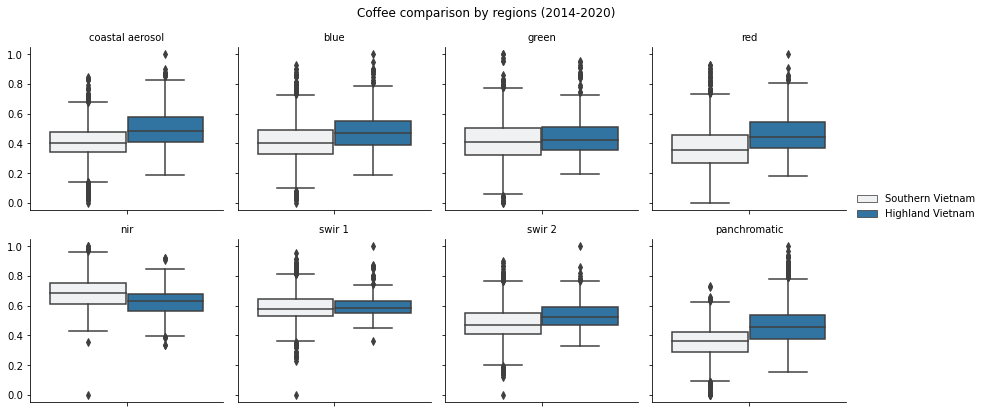

In [30]:
statistics(['./Vietnam_2014_2020/merged.tif'], [Label.COFFEE], group_names, labels_coordinates_list, 'Coffee comparison by regions (2014-2020)', True, True)

# Coffee comparison by districts (2014 - 2020)

In [31]:
group_names = [
    'Gia Lai',
    'Dak Lak',
    'Dak Nong',
    'Lam Dong'
]

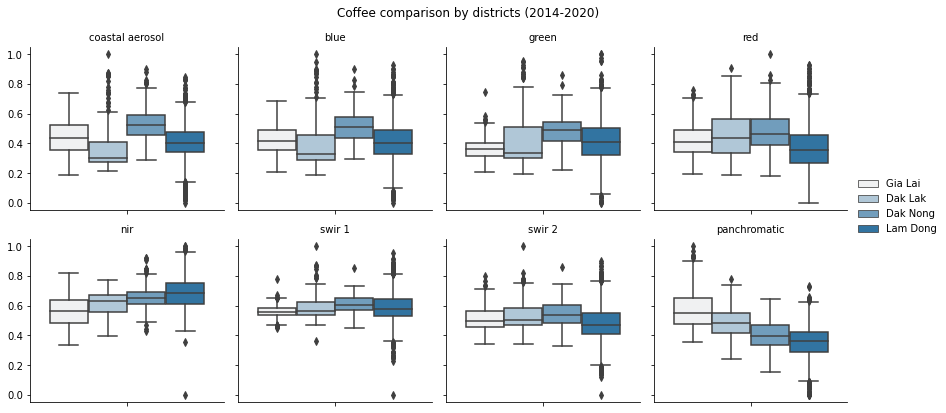

In [32]:
statistics(['./Vietnam_2014_2020/merged.tif'], [Label.COFFEE], group_names, DISTRICTS_COORDINATES, 'Coffee comparison by districts (2014-2020)')

# Coffee comparison by soil types (2014 - 2020)

In [33]:
group_names = [
    'Acric Ferrasols',
    'Ferric Acrisols',
    'Orthic Acrisols',
    'Rhodic Ferrasols',
    'Orthic Ferrasols'
]

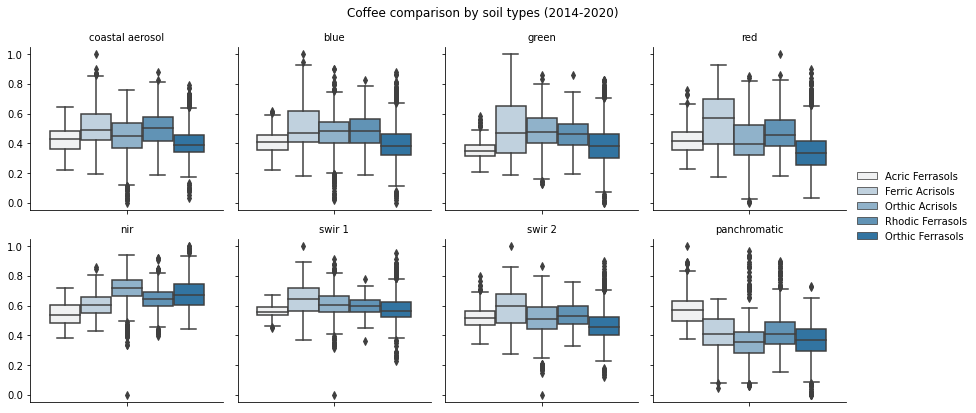

In [34]:
statistics(['./Vietnam_2014_2020/merged.tif'], [Label.COFFEE], group_names, SOILS_COORDINATES, 'Coffee comparison by soil types (2014-2020)')